## 1. Introduction
### Dataset: Breast Cancer Wisconsin Diagnostic

### Objective: Binary classification (malignant or benign)

### Approach: Logistic Regression with Gradient Descent + Feature Selection (RFE)

### Evaluation: Accuracy, Decision Boundary, Convergence, Feature Weights
___

### Import Libraries and the dataset

In [213]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy, math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import metrics

## 2. Data Preprocessing
### Load dataset

In [214]:
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

The Breast Cancer dataset from sklearn.datasets is not a DataFrame by default — it's a Bunch object, which is basically like a dictionary. so .info() or .head() function will give an error since it is not a pandas dataframe.

### Convert it to dataframe for better representation.

In [216]:
df = pd.DataFrame(X, columns= dataset.feature_names)
df['target'] = y
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Split into training and testing set.

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

### Normalize features.

In [218]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Logistic Regression from Scratch


Theoretical Background and **Courtesy** :

The formulas and brief explanations in this section are adapted from **Andrew Ng’s Machine Learning Specialization**. These resources were used while learning logistic regression from scratch.
However, the main logic of python functions below were the assignments of the course and they are **independently developed**.

### Cost function ()
For logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is:

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
*  where m is the number of training examples in the data set and:
$$
\begin{align}
  f_{\mathbf{w},b}(\mathbf{x^{(i)}}) &= g(z^{(i)})\tag{3} \\
  z^{(i)} &= \mathbf{w} \cdot \mathbf{x}^{(i)}+ b\tag{4} \\
  g(z^{(i)}) &= \frac{1}{1+e^{-z^{(i)}}}\tag{5} 
\end{align}
$$
 

In [219]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

In [220]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
             
    cost = cost / m
    return cost

Gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   

In [221]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw 

### Gradient Descent Code 
The code implementing equation (1) above is implemented below. 

In [222]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing

### Train model with gradient descent

In [223]:
w_init = np.zeros(X_train_scaled.shape[1])  # shape (n,)
b_init = 0.0
alpha = 0.01       # learning rate
iterations = 1000  # number of iterations

w_final, b_final, J_history = gradient_descent(X_train_scaled, y_train, w_init, b_init, alpha, iterations)

Iteration    0: Cost 0.6730105265248857   
Iteration  100: Cost 0.24363379740798397   
Iteration  200: Cost 0.1818386693346216   
Iteration  300: Cost 0.1537234647604074   
Iteration  400: Cost 0.1370551010272266   
Iteration  500: Cost 0.12581447285850794   
Iteration  600: Cost 0.11761430660519918   
Iteration  700: Cost 0.11130681924700699   
Iteration  800: Cost 0.10626754077232767   
Iteration  900: Cost 0.10212541156266354   


## 4. Visualize Convergence


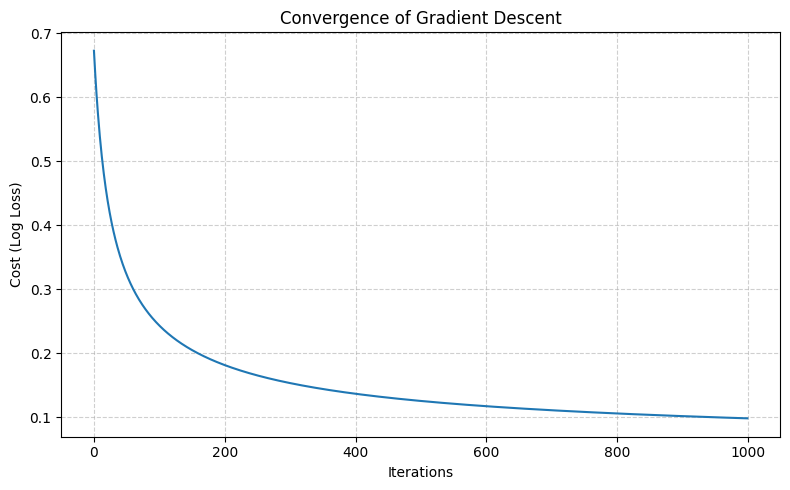

In [224]:
plt.figure(figsize=(8,5))
plt.plot(J_history)
plt.title("Convergence of Gradient Descent")
plt.xlabel("Iterations")
plt.ylabel("Cost (Log Loss)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Model is learning and converging properly.

## 5. Model Evaluation


In [225]:
def predict(X, w, b):
    z = np.dot(X, w) + b
    probs = sigmoid(z)
    return probs >= 0.5  # returns boolean array

In [226]:
y_pred = predict(X_test_scaled, w_final, b_final)

Test Accuracy: 97.37%


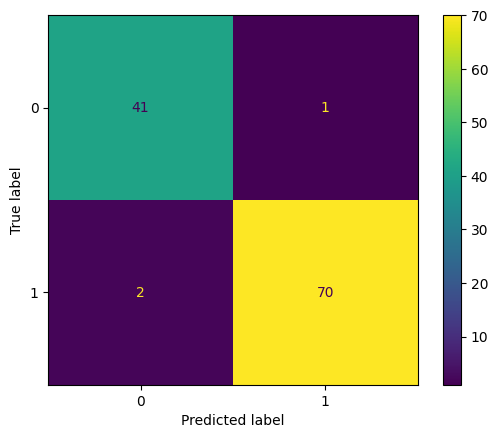

In [227]:
acc = np.mean(y_test == y_pred) 
print(f"Test Accuracy: {acc * 100:.2f}%")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()


(y_test == y_pred) : Creates a boolean array (e.g., [True, True, False, ...]) showing which predictions are correct.

np.mean(...) : Converts True to 1 and False to 0, then calculates the average. This gives the fraction of correct predictions. (If 90 out of 100 predictions are correct, the mean will be 0.9.)

# Test Accuracy: 97.37%

In [228]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred_sklearn = lr.predict(X_test_scaled)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Sklearn Logistic Regression Accuracy: {acc_sklearn * 100:.2f}%")

Sklearn Logistic Regression Accuracy: 98.25%


## 6. Interpret Model Weights


In [229]:
for feature, weight in zip(dataset.feature_names, w_final):
    print(f"{feature}: {weight:.4f}")


mean radius: -0.3899
mean texture: -0.3562
mean perimeter: -0.3850
mean area: -0.3811
mean smoothness: -0.1761
mean compactness: -0.1478
mean concavity: -0.2649
mean concave points: -0.3768
mean symmetry: -0.1398
mean fractal dimension: 0.1571
radius error: -0.3249
texture error: -0.0001
perimeter error: -0.2748
area error: -0.3138
smoothness error: 0.0088
compactness error: 0.0920
concavity error: 0.0943
concave points error: -0.0816
symmetry error: 0.0706
fractal dimension error: 0.1885
worst radius: -0.4492
worst texture: -0.4147
worst perimeter: -0.4319
worst area: -0.4232
worst smoothness: -0.2987
worst compactness: -0.2168
worst concavity: -0.2780
worst concave points: -0.4126
worst symmetry: -0.2811
worst fractal dimension: -0.0972


###  Interpreting Feature Weights

- **Positive weight** → Higher value increases chance of **benign** (class 1)  
- **Negative weight** → Higher value increases chance of **malignant** (class 0)  
- **Larger magnitude** → Stronger influence on prediction   

Features with high absolute weights contribute more to prediction.

### Highlight influential features

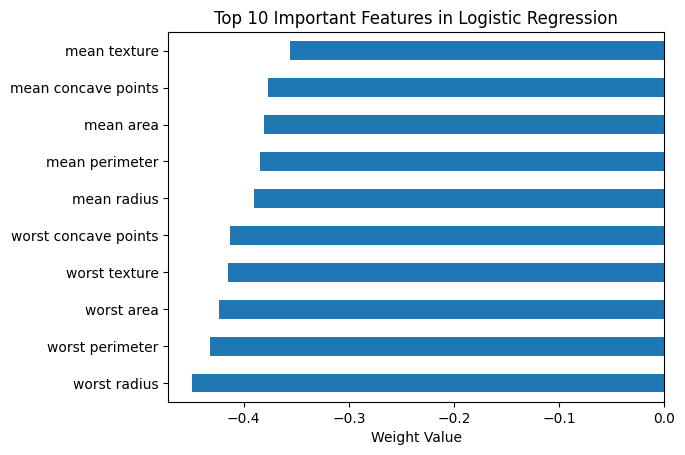

In [230]:
# Plot top 10 features
weights = pd.Series(w_final, index=dataset.feature_names)
weights_abs_sorted = weights.abs().sort_values(ascending=False).head(10)

weights[weights_abs_sorted.index].plot(kind='barh')
plt.xlabel("Weight Value")
plt.title("Top 10 Important Features in Logistic Regression")
plt.show()


## 9. Visulaise Decision Boundry


#### Dimensionality Reduction

In [231]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### Train logistic regression on 2D data

In [232]:
# Retrain gradient descent on PCA-reduced X.
# Re-initialise w and b.
w_pca = np.zeros(2)
b_pca = 0
w_pca, b_pca, _ = gradient_descent(X_train_pca, y_train, w_pca, b_pca, alpha=0.1, num_iters=1000)


Iteration    0: Cost 0.52351088618619   
Iteration  100: Cost 0.1358790254666347   
Iteration  200: Cost 0.12528511399487496   
Iteration  300: Cost 0.1218630887102907   
Iteration  400: Cost 0.12032042662421864   
Iteration  500: Cost 0.11951267790071816   
Iteration  600: Cost 0.11905244557807622   
Iteration  700: Cost 0.11877578450419593   
Iteration  800: Cost 0.11860328558299936   
Iteration  900: Cost 0.11849287907267024   


### Plot decision Boundry

/var/folders/vp/4637syr17gq79cb8mjcw_gb40000gn/T/ipykernel_52355/1794815780.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


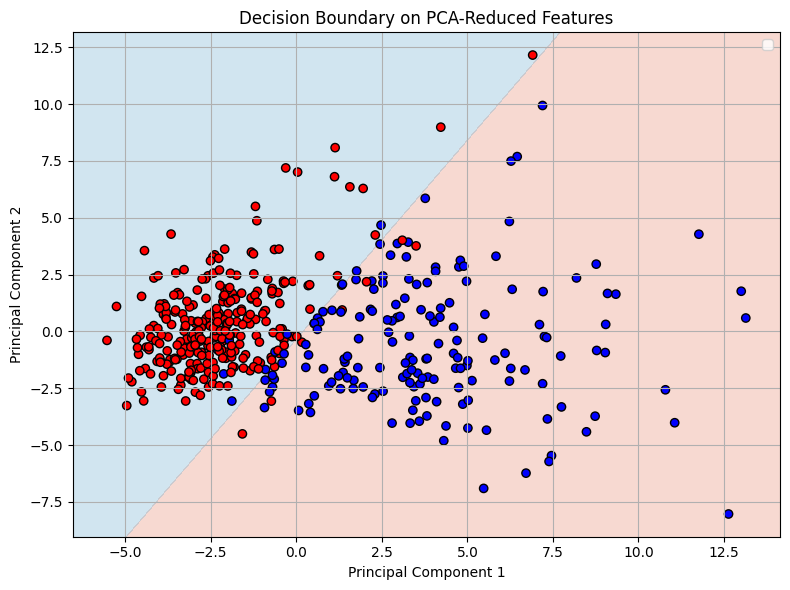

In [233]:
# Create grid to plot decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict on grid
Z = sigmoid(w_pca[0]*xx + w_pca[1]*yy + b_pca)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, cmap='RdBu')
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='bwr', edgecolor='k')
plt.title("Decision Boundary on PCA-Reduced Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Red dots:	Data points where y_train = 0 → Malignant,  
Blue dots:	Data points where y_train = 1 → Benign,  
Red area (background):	Region where model predicts malignant (0) with probability < 0.5,  
Blue area (background):	Region where model predicts benign (1) with probability > 0.5

## Recursive Feature Elimination

### Select top 10 features

In [234]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Use L2 regularization with 'liblinear' solver (commonly compatible)
model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

# Recursive Feature Elimination - select top 10 features
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Selected top features
cl = dataset.feature_names
X_train_scaled_ = pd.DataFrame(X_train_scaled, columns=cl)
selected_features = X_train_scaled_.columns[selector.support_]
print("Top 10 Selected Features by RFE:\n", selected_features)


Top 10 Selected Features by RFE:
 Index(['mean radius', 'mean concavity', 'mean concave points', 'mean symmetry',
       'mean fractal dimension', 'worst radius', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst symmetry'],
      dtype='object')


In [243]:
# Train logistic regression
model_sel = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2')
model_sel.fit(X_train_scaled, y_train)

# Predict
y_pred_sel = model_sel.predict(X_test_scaled)

# Accuracy
acc_sel = accuracy_score(y_test, y_pred_sel)
print(f" Accuracy with RFE-selected features and Sk_learn's Logistic Regressor: {acc_sel * 100:.2f}%")


 Accuracy with RFE-selected features and Sk_learn's Logistic Regressor: 98.25%
